# CEE 598: Uncertainty Quantification
## Assignment Four
### Noah Garfinkle (garfink2@illinois edu)
### 12 March 2020

## Imports and Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import pandas as pd
import time

## Problem 1.

Consider a modification of the famous "braking data" of Tukey (1977) given below.  Note that for some speed ($x$) values two distance ($y$) values are given and separated by a comma.  The two values are obtained from two independent experiments.  A quadratic model is to be built resulting in the following measurement equation

$$
y = a + bx + cx^2 + \epsilon
$$

where $\epsilon \sim N(0,\sigma^2 = 2^2)$.  We need to estimate the parameters $a$, $b$, and $c$ in this model in a probabilistic way.  Consider the prior density fucntions of these parameters are given as follows:

$$
a \sim \pi(a) = N(1,\sigma^2=5^2)
$$

$$
b \sim \pi(b) = N(0.2,\sigma^2=0.05^2)
$$

and

$$
c \sim \pi(c) = N(0.2,\sigma^2=0.05^2)
$$

Use your Metropolis-Hastings code to generate the posterior histograms of these three parameters, using 10,000 posterior samples.  You can choose the proposal however you like.  Discuss:

- Your choice of proposal,
- It's impact on the outcome,
- The convergence property,
- Acceptance rates, and
- Other interesting points about your results

Methodology

- Generate random pulls of a,b,c
- Use those to calculate y for a breaking value and compare to the actual
- Center the error function on y and use that to estimate the liklihood
- Use the liklihood as part of the MCMC acceptance criteria
- Instead of having one accepted argument, I will have three (a,b,c)
- Plot those as the posterior histograms?  Or use Bayes rule?

In [9]:
def π_normal(x,σ):
    normalDist = stats.norm(loc=x,scale=σ)
    proposedValue = normalDist.rvs()
    return proposedValue

In [10]:
def π(mean=[1,0.2,0.2,0],cov=np.diag([5,0.05,0.05,2])):
    normalDist = stats.multivariate_normal(mean=mean,cov=cov)
    proposedValues = normalDist.rvs()
    return proposedValues

In [11]:
xs = [4,7,8,9,10,11,12,13,14,15,16,17,18,19,20,22,23,24,25]
ys_1 = [2,4,16,10,18,17,14,26,26,20,32,32,42,36,32,66,54,70,85]
ys_2 = [10,22,None,None,26,28,20,34,36,26,40,40,56,46,48,None,None,92,None]
df_prob1 = pd.DataFrame({"x":xs,"y1":ys_1,"y2":ys_2})

Text(0, 0.5, '$y$ = distance to stop (feet)')

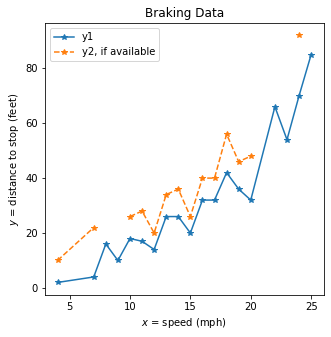

In [12]:
fig,ax = plt.subplots(figsize=(5,5))
ax.plot(xs,ys_1,label="y1",marker="*")
ax.plot(xs,ys_2,label="y2, if available",marker="*",ls="--")
ax.legend()
ax.set_title("Braking Data")
ax.set_xlabel("$x$ = speed (mph)")
ax.set_ylabel("$y$ = distance to stop (feet)")

In [13]:
a,b,c,ϵ = π()

In [14]:
def predict_y(x,a,b,c,ϵ):
    y = a + b * x + c * x * x + ϵ
    return y

In [15]:
predictions = [predict_y(x,a,b,c,ϵ) for x in xs]

Text(0, 0.5, '$y$ = distance to stop (feet)')

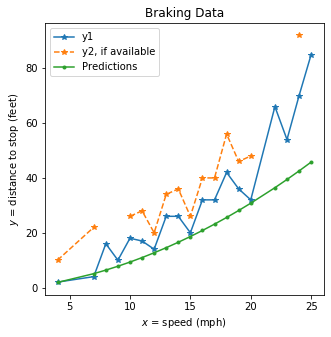

In [16]:
fig,ax = plt.subplots(figsize=(5,5))
ax.plot(xs,ys_1,label="y1",marker="*")
ax.plot(xs,ys_2,label="y2, if available",marker="*",ls="--")
ax.plot(xs,predictions,label="Predictions",marker='.')
ax.legend()
ax.set_title("Braking Data")
ax.set_xlabel("$x$ = speed (mph)")
ax.set_ylabel("$y$ = distance to stop (feet)")

Migrating and adapting my Metropolis-Hastings code from Assignment Three to function on multi-dimensional problems:

In [ ]:
run code for abc, puy y value as mean of error, use log of liklihood
log?(α)=logpzlogpd|z-logpz-logpd|z

In [17]:
def f_rayleigh(x,σ):
    p = x / np.power(σ,2)*np.exp(-np.power(x,2)/(2*np.power(σ,2)))
    return p

In [18]:
# I think what actually needs to happen here with my proposal is a normal distribution centered on x and with σ
def q_x(x,σ):
    normalDist = stats.norm(loc=x,scale=σ)
    proposedValue = normalDist.rvs()
    return proposedValue

In [19]:
def metropolisHastings(x=1.0,σ=1,σ_q=1,n=10000):
    iterations = []
    xs = []
    ys = []
    zs = []
    proposedXs = []
    proposedYs = []
    proposedZs = []
    arr_Accepted = []

    for t in range(0,n):
        # obtain a proposed value from q
        proposedValue = q_x(x,σ_q)
        # calculate the acceptance probability
        acceptanceRatio = min(1,f_rayleigh(proposedValue,1) / f_rayleigh(x,1) * stats.norm.pdf(x,scale=σ_q,loc=proposedValue) / stats.norm.pdf(proposedValue,scale=σ_q,loc=x))
        accepted = False
        if acceptanceRatio == 1: #accept
            x = proposedValue
            accepted = True
        else: # draw a random number and take the probability from acceptanceRatio
            rand = np.random.random()
            if rand < acceptanceRatio:
                x = proposedValue
                accepted = True
            else:
                pass
        iterations.append(t)
        xs.append(x)
        proposedXs.append(proposedValue)
        arr_Accepted.append(accepted)
    df = pd.DataFrame({"t":iterations,"x":xs,"proposals":proposedXs,"accepted":arr_Accepted})
    
    df_Accepted = df[df["accepted"]==True]
    df_Rejected = df[df["accepted"]==False]

    fig,ax = plt.subplots(figsize=(10,5))
    ax.scatter(df_Accepted["t"],df_Accepted["x"],label="Accepted",marker=".",color="green")
    ax.scatter(df_Rejected["t"],df_Rejected["proposals"],label="Rejected",marker="x",color="red")
    ax.legend()
    ax.set_xlabel("Iteration")
    ax.set_ylabel("$x$")
    
    xs = np.linspace(0,10,100)
    fs_rayleigh = [f_rayleigh(x,1) for x in xs]
    fig,ax = plt.subplots(figsize=(10,10))
    sns.lineplot(xs,fs_rayleigh,label="Rayleigh distribution",ax=ax)
    sns.kdeplot(df["x"],ax=ax,label="Metropolis Hastings")
    ax.legend()
    
    return df

In [ ]:
metropolisHastings()

## Problem Two

You are asked to estimate the mechanical property (specifically the elastic modulus) of the material used in a set of manufactured truss members.  You have access to the experiments carried otu on a number of truss structures (as shown in the Figure) made from these elements.  Specifically, you are provided with the displacements at a number of nodes.  Assume all the truss bars have the same elastic modulus.

In order to use Bayesian inference, a structural analysis code is provided that calculates the displacements under different loadings.  The code is available in the 'Truss Analysis' folder on Piazza, together with the documentation file ('Help.pdf').  Try to get familiar with the code and its inputs and outputs, and verify that for $YM=1e7$, your outputs match those given in the documentation.

The measurement equation is as follows:

$$
y = g(E) + \epsilon
$$

where $g(E)$ is the displacement given by the model and $\epsilon \sim N(0,\sigma^2 = 0.01^2)$ is the measurement noise.

Approach:

Because I am not familiar with MATLAB, I have opted to replicate the MATLAB functions Data.m and ST.m using Python.

Steps to run the MATLAB code for my reference:
1. D=Data(1e7)
2. [F,U,R] = ST(D)
3. TP(D,U,20)

In [2]:
class Data:
    def __init__(self,YM):
        self.YM = YM
        self.Coord = []
        self.Con = []
        self.Re = []
        self.Load = []
        self.E = []
        self.A = []
        
        self.createCoord()
        self.createCon()
        self.createRE()
        self.createLoad()
        self.createE()
        self.createA()
        
    def createCoord(self):
        coords=np.array([-37.5,0,200,37.5,0,200,-37.5,37.5,100,37.5,37.5,100,37.5,-37.5,100,-37.5,-37.5,100,-100,100,0,100,100,0,100,-100,0,-100,-100,0])
        coords_x = []
        coords_y = []
        coords_z = []
        index = 0
        for coord in coords:
            if index == 0:
                coords_x.append(coord)
            elif index == 1:
                coords_y.append(coord)
            elif index == 2:
                coords_z.append(coord)
            else:
                print("ERROR")
            index += 1
            if index == 3:
                index = 0
        df_coords = pd.DataFrame({"x":coords_x,"y":coords_y,"z":coords_z})
        self.Coord = df_coords
        
    def createCon(self):
        Con=[1,2,1,4,2,3,1,5,2,6,2,4,2,5,1,3,1,6,3,6,4,5,3,4,5,6,3,10,6,7,4,9,5,8,4,7,3,8,5,10,6,9,6,10,3,7,4,8,5,9]
        con_starts = []
        con_ends = []
        index = 0
        for node in Con:
            if index == 0:
                con_starts.append(node)
            elif index == 1:
                con_ends.append(node)
            else:
                print("ERROR")
            index += 1
            if index == 2:
                index = 0
        df_connections = pd.DataFrame({"start":con_starts,"end":con_ends})
        self.Con = df_connections
    
    def createRE(self):
        Re = np.zeros((10,3))
        Re[6:10,:] = 1
        self.Re = Re
    
    def createLoad(self):
        Load = np.array([[1,-10,-10],[0,-10,-10],[0.5,0,0],[0,0,0],[0,0,0],[0.6,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0]]) * 1e3;
        self.Load = Load
    
    def createE(self):
        E = np.array([self.YM for i in range(0,25)])
        self.E = E
    
    def createA(self):
        A = np.array([.4,.1,.1,.1,.1,3.4,3.4,3.4,3.4,.4,.4,1.3,1.3,.9,.9,.9,.9,1,1,1,1,3.4,3.4,3.4,3.4])
        self.A = A

In [3]:
def ST(D):
    w = D.Re.shape # Note, reversed from MATLAB
    S = np.zeros((3*w[0],3*w[0]))
    U = 1 - D.Re
    f = [i for i in range(0,18)] # shifted one because zero index

    Tj = np.zeros((3,25))
    for i,row in D.Con.iterrows():
        H = np.array([row["start"],row["end"]])
        # calculate the length in each coordinate, subtracting one to make
        # up for the difference in index between Matlab and Python
        C_x = D.Coord.iloc[row["end"]-1].x - D.Coord.iloc[row["start"]-1].x
        C_y = D.Coord.iloc[row["end"]-1].y - D.Coord.iloc[row["start"]-1].y
        C_z = D.Coord.iloc[row["end"]-1].z - D.Coord.iloc[row["start"]-1].z
        C = np.array([C_x,C_y,C_z]) # good
        # norm
        Le = np.linalg.norm(C) # good
        T = C/Le
        T = T[np.newaxis] # good, https://stackoverflow.com/questions/5954603/transposing-a-numpy-array
        s = T * np.transpose(T) # good
        G=D.E[i]*D.A[i]/Le # good
        Tj[:,i] = G*T # looks good!
        e1 = [j for j in range(3*H[0]-3,3*H[0])]
        e2 = [j for j in range(3*H[1]-3,3*H[1])]
        e = np.array(e1 + e2) # good I think, all indices are shifted down one
        goofyArray = np.zeros((len(s)*2,len(s)*2))
        goofyArray[0:3,0:3] = s # upper left quadrant
        goofyArray[0:3,3:] = -s # upper right quadrant
        goofyArray[3:,0:3] = -s # lower left quadrant
        goofyArray[3:,3:] = s # lower right quadrant
        goofyArray *= G
        S[np.ix_(e,e)] += goofyArray #This was absurdly tricky but I think this works!!! # https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html

    # Now find U, which proceeds row-wise 
    goofyArray2 = S[np.ix_(f,f)]
    # D.Load(f) is the first 18 values of D.Load rowwise, I have no idea why
    DLoadf = np.array(list(D.Load[0])+list(D.Load[1])
                      +list(D.Load[2])+list(D.Load[3])
                      +list(D.Load[4])+list(D.Load[5]))
    goofyArray3 = np.linalg.solve(goofyArray2,DLoadf) # this is equivalent to S(f,f)\D.Load(f)
    U[0,:] = goofyArray3[0:3]
    U[1,:] = goofyArray3[3:6]
    U[2,:] = goofyArray3[6:9]
    U[3,:] = goofyArray3[9:12]
    U[4,:] = goofyArray3[12:15]
    U[5,:] = goofyArray3[15:18]

    dcon = D.Con.to_numpy() # good
    dcon = dcon - 1 # good, correcting for zero index
    # U(:,D.Con(2,:)) -> I think I figured this out, start at the first row of U and place there the value of the location by index
    F = np.sum(Tj.T * (U[np.ix_(dcon[:,1])] - U[np.ix_(dcon[:,0])]),axis=1) # good!  This took hours to figure out how to replicate!
    toBeReshaped = np.dot(S,U.reshape(30,1)) # good!
    R = np.reshape(toBeReshaped,(10,3)).T # good I think!
    R[:,0] = 0.0
    R[:,1] = 0.0
    R[:,2] = 0.0
    R[:,3] = 0.0
    R[:,4] = 0.0
    R[:,5] = 0.0
    return F,U,R

In [4]:
D=Data(1e9)
F,U,R = ST(D)

In [5]:
F

array([  -336.319792  ,   -240.28037334,    629.17339468,   -914.55709256,
          -43.95977576,   8385.1090718 , -19544.03334719,   9096.64146254,
       -18831.56511371,   -256.68085568,   -294.53292772,   2846.23109304,
        -6881.61977941,   2270.22933694,  -3767.64589843,   2002.80710339,
        -4035.46494973,   1887.31843132,   1736.16818133,  -4046.77307179,
        -4288.09760868, -17642.58471495,   9059.2610844 ,   7366.58537374,
       -19403.74638901])

In [6]:
U

array([[ 1.13129821e-03, -3.48893089e-03, -4.54721534e-04],
       [ 1.06823825e-03, -3.47935931e-03, -5.21572758e-04],
       [-4.75340804e-05,  1.76537878e-04,  6.14656998e-04],
       [ 1.16671560e-04,  1.72128424e-04,  5.66433231e-04],
       [-1.55645424e-04,  2.27353348e-04, -1.25593080e-03],
       [ 2.41371102e-04,  2.24665538e-04, -1.21556272e-03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [8]:
R

array([[     0.        ,      0.        ,      0.        ,
             0.        ,      0.        ,      0.        ,
         -4375.03715424,   3375.22883543, -11650.57800004,
         10550.38631885],
       [     0.        ,      0.        ,      0.        ,
             0.        ,      0.        ,      0.        ,
          2033.65948028,    985.54568849,   9045.8959927 ,
          7934.89883853],
       [     0.        ,      0.        ,      0.        ,
             0.        ,      0.        ,      0.        ,
         -5749.78093578,  -4250.21906422,  15800.21906422,
         14199.78093578]])

### Part 2.1

First, consider a single truss structure is made and tested.  Assume a uniform prior for the eleastic modulus in the range $[5e6,5e7]$.  Find the posterior distribution for the elastic modulus under the following scenarios:

#### a. We have measured the displacement of node 2 in x-direction is 0.1128.  Estimate elastic modulus (probabilistically) using this single observation).

#### b. We have measured the displacemetn of node 2 in the three directions as $[0.1128,,-0.3636,-0.0577]$.  Estimate the elastic modulus using this observation.

#### c. We have measured the displacement of node 1 as $[0.1084,-0.3474,-0.0286]$, and the displacement of node 2 as $[0.1128,-0.3636,-0.0577]$.

Compare and discuss the results pertaining to these cases.

### Part 2.2

Now, consider a number of 50 truss structures are made and tested and node 2 displacements in $x$, $y$, and $z$ directions are recorded for each experiment.  The file 'observations.txt' includes the recorded displacements.  Assuming a uniform prior for the elastic modulus in the same range ($[5e6,5e7]$), estimate the posterior pdf for the elastic modulus given these observations.  In particular, calculate three different posterior pdfs for three difference cases where 5, 20, and finally all 50 tests are used.  Compare and discuss the results.